# Forward model

In [55]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import spherical_volume, volume_fourier, volume_comp, mip_z
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

### Create volume

Text(0.5, 1.0, 'Volume_comp MIP')

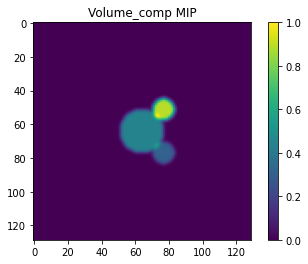

In [60]:
shape = np.array([129,129,129])
dimensions = np.array([20,20,20])

# A volume with components
centres = np.array([[0,0,0], [2, 2, 0], [2, -2, 0]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

v = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, True))

mip_z(v)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

0.23797297477722168


Text(0.5, 1.0, 'Vol FFT slice')

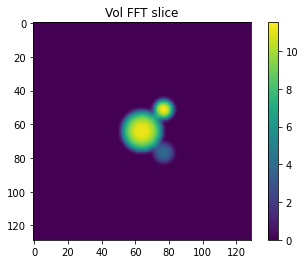

In [64]:
angles = jnp.array([0,0,0])

start = time.time()
v_slice = project_spatial(v, angles, dimensions)
print(time.time()-start)


plt.imshow(v_slice); plt.colorbar()
plt.title('Vol FFT slice')

In [65]:
@jax.jit
def slice_func(angles):
    return project_spatial(v, angles, dimensions)

@jax.jit
def slice_func_array(angles):
    return jnp.apply_along_axis(slice_func, 1, angles)

In [68]:
angles = jnp.array([np.pi,np.pi/3*2,np.pi/4])

start = time.time()
s1 = slice_func(angles)
print(time.time()-start)

start = time.time()
s2 = slice_func_array(jnp.array([angles]))
print(time.time()-start)

0.042236328125
0.043715715408325195


In [73]:
angles_true = jnp.array(np.random.rand(100,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(angles_true)
print(time.time()-start)

print(angles_true.shape)
print(imgs.shape)

0.11588001251220703
(100, 3)
(100, 129, 129)


In [74]:
@jax.jit
def loss_func(a, img):
    return 1/(2* 16641) * jnp.sum((slice_func(a) - img)**2)

@jax.jit 
def loss_func_array(a, imgs):
    return jax.vmap(loss_func, in_axes = (0,0))(a, imgs)

@jax.jit
def dloss_array(a, imgs):
    return jax.vmap(jax.grad(loss_func))(a, imgs)


In [78]:
start = time.time()
l = loss_func_array(angles_true, imgs)
print(time.time()-start)
print(jnp.max(jnp.abs(l)))

0.11788702011108398
0.0


In [82]:
start = time.time()
dl = dloss_array(angles_true, imgs)
print(time.time()-start)
print(jnp.sum(jnp.abs(dl)))

0.23788118362426758
0.0


In [83]:
#a0 = jnp.array(np.random.rand(100,3))*jnp.pi*2
a0 = jnp.array(angles_true + 0.1 * np.random.randn(100,3))
alpha = 0.01
a = a0
iters = 20
for i in range(iters):
    #if np.mod(i,100) == 0:
        #print(i)
    print(str(i) + ": loss = " + str(jnp.mean(loss_func_array(a, imgs))))

    a = a - alpha * dloss_array(a, imgs)

0: loss = 0.042730197
1: loss = 0.0394783
2: loss = 0.036458585
3: loss = 0.033668652
4: loss = 0.031108065
5: loss = 0.028770084
6: loss = 0.026634807
7: loss = 0.024691159
8: loss = 0.022916984
9: loss = 0.021291064
10: loss = 0.019806778
11: loss = 0.018434616
12: loss = 0.0171805
13: loss = 0.016036099
14: loss = 0.014985656
15: loss = 0.014028452
16: loss = 0.013155384
17: loss = 0.012361431
18: loss = 0.0116285775
19: loss = 0.010958388


In [84]:
jnp.mean(a - jnp.array(angles_true))

DeviceArray(0.00276463, dtype=float32)

## Nearest neighbour interpolation

0.3005681037902832


Text(0.5, 1.0, 'NN')

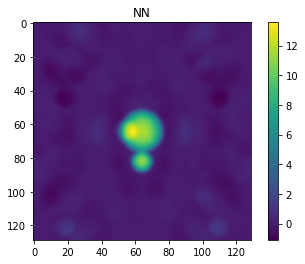

In [88]:
start = time.time()
slice_nn = project_spatial(v, angles, dimensions, "nn")
print(time.time()-start)


plt.imshow(slice_nn); plt.colorbar()
plt.title("NN")